map.ipynb (TODO can choose a more descriptive name for this file)  

Notebook for plotting an integrated column map of desired output from static wether  
Created by cloud academy participants.
2018.09.26 uplaoded c.j.baxter@uva.nl

Requirements:  
       matplotlib, numpy, basemap  
Installations:   
   conda install -c conda-forge basemap  
   conda install -c conda-forge proj4  

In [1]:
# imports 
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np

In [2]:
# custom imports 
from column import *
from read_file import read_file
from readinLatLong import get_foldernames

# Read in data

In [3]:
# Read in the folders containing the outputs
fnames = get_foldernames(root = 'static_weather_results/HATP_7b')
lons = np.sort(np.unique([float(key[0]) for key in fnames.keys()]))
lats = np.sort(np.unique([float(key[1]) for key in fnames.keys()]))
# Add in the negative latitudes to lats array
lats = np.sort(np.concatenate((-lats[1:],lats)))

In [17]:
# Choose the variable keyword for mapping
#keyword = b'b_Al2O3[s]'
keyword = b'T'

datafile = 'out3_chem1.dat' # (TODO) this could be more general, e.g. a 
                            # function find which files contain the required 
                            # variable for plotting 

# Z is our mapping variable array
Z = np.zeros((len(lats),len(lons)))

# Loop over all the files, integrate and fill in Z array.
# Also append the integrated column to the negative latitudes in Z
for key in fnames.keys():
    lon, lat = key
    fname = fnames[key]
    data = read_file(fname + datafile)
    output = integrate_column(data, keyword)
    latind_p = np.where(lats == float(lat))[0][0]
    latind_n = np.where(lats == -float(lat))[0][0]
    lonind = np.where(lons == float(lon))[0][0]
    Z[latind_p][lonind] = output
    Z[latind_n][lonind] = output

# Hack to deal with missing values in Z array
# (TODO) fix this so that we can still make the map with mising data. 
# Right now this -99 is showing up at the blue regions, it would be good 
# if we could interpolate over these missing regions.
Z = np.log10(np.maximum(Z,1e-99))

In [53]:
# Find the locations of anomalous data. 
mins = np.where(Z<18) # for temperature...
print (lats[mins[0]])
print (lons[mins[1]]) 

[-67.5 -45.  -45.    0.   45.   45.   67.5]
[  60. -165.   60.  135. -165.   60.   60.]


# Plotting the map

/Users/cbaxter/anaconda/envs/CloudAcademy/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


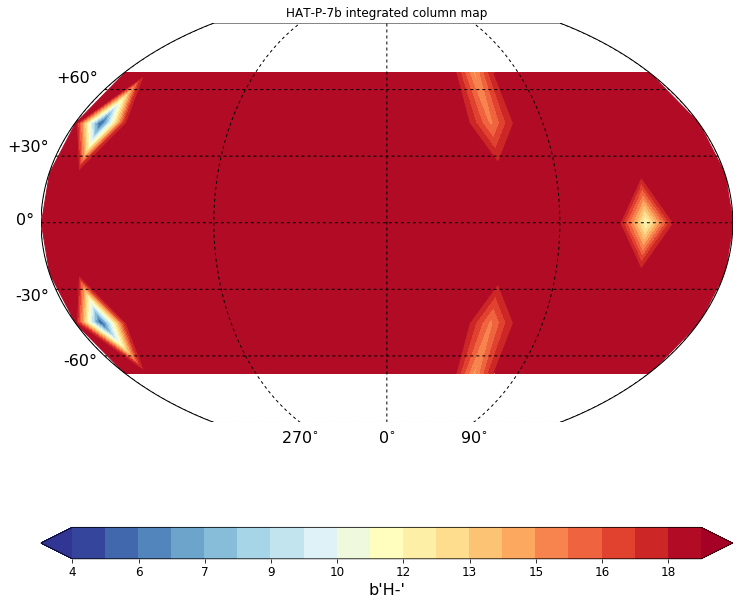

In [22]:
# X,Y grid is length lons * lats - Z array has to be shape (len(Y),len(X))
X, Y = np.meshgrid(np.sort(lons),np.sort(lats))

# Initilise figure object
fig = plt.figure( figsize = (10,10) )
ax = fig.add_subplot(111)

# we use the basemap package for easier global variable plotting
# install with anaconda using: conda install -c conda-forge basemap
# for availible projections see: https://matplotlib.org/basemap/users/mapsetup.html
# lon_0 is the longitude of the zero (center) point
m = Basemap(projection='kav7',lon_0=0,resolution=None)

# Find levels between max and min of mapped variable
nlev = 20
levels = np.linspace(np.amin(Z[Z>0]),np.amax(Z),nlev)
# Colour map
cmap = plt.cm.RdYlBu_r

# Plot data as filled contour
CS = m.contourf(X,Y,Z,levels=levels,extend='both',cmap=cmap,latlon=True)

# Colour bar and formatting
for c in CS.collections:
    c.set_edgecolor("face")
CB = plt.colorbar(CS, orientation='horizontal', format="%d")
CB.set_label(keyword, size=16)
CB.ax.tick_params(labelsize=12)

# Title is chosen pressure level
plt.title('HAT-P-7b integrated column map')

# Increase size of labels
plt.tick_params(axis='both', which='major', labelsize=16)

# String formatting function
def fmtfunc(inlon):
    string = r'{:g}'.format(inlon)+r'$^{\circ}$'
    #print string
    return string

# Plot lat-lon lines on map
color1='k'
meridians = np.arange(0.,360.,90)
m.drawmeridians(meridians,labels=[False,False,False,True],labelstyle=None,
                fmt=fmtfunc,dashes=[3,3],color=color1,fontsize=16)
parallels = np.arange(-90.,90,30)
m.drawparallels(parallels,labels=[True,False,False,False],labelstyle='+/-',
                dashes=[3,3],color=color1,fontsize=16)
# Save figure
plt.tight_layout(pad=1.05, h_pad=None, w_pad=None, rect=None)
plt.savefig('HAT-P-7b_{}_map_initial.pdf'.format(keyword),dpi=144,bbox_inches='tight')

# Show figure
plt.show()